# 盐城上牌量预测

## 数据读取

In [1]:
import numpy as np
import pandas as pd

In [2]:
all_data_df = pd.read_csv("./Input/train_data_0225_corect_su.csv",index_col = 0)

In [3]:
all_data_df.head()

,index,date_t.1,date_ext_t,cnt,date,day_of_week,dow_diff,is_sa,is_su,year,...,is_holiday,is_WDA,in_Jan,in_Oct,in_Feb,is_Joker,near_mid_autum,near_national_day,near_festival_day,total_sales
date_t,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.0,2013-01-02,2013-01-02,68.0,1.0,2,0.0,0.0,0.0,2013,...,1,0,0,0,0,0,68.0,68.0,68.0,35528
2013-01-03,1.0,2013-01-03,2013-01-03,36.0,2.0,3,1.0,0.0,0.0,2013,...,1,0,0,0,0,0,36.0,36.0,36.0,35528
2013-01-04,2.0,2013-01-04,2013-01-04,5565.0,3.0,4,1.0,0.0,0.0,2013,...,0,0,4,0,0,0,5565.0,5565.0,5565.0,35528
2013-01-05,3.0,2013-01-05,2013-01-05,4966.0,4.0,5,1.0,1.0,0.0,2013,...,0,1,5,0,0,0,4966.0,4966.0,4966.0,35528
2013-01-06,4.0,2013-01-06,2013-01-06,3346.0,5.0,6,1.0,0.0,1.0,2013,...,0,1,6,0,0,0,3346.0,3346.0,3346.0,35528


In [4]:
all_data_df.shape

(1507, 24)

In [5]:
all_feature_df = all_data_df.drop(["index","date_t.1"],axis = 1)

In [6]:
# all_feature_df["date_t"]=all_feature_df["date_t"].apply(pd.to_datetime)
# all_feature_df["date_ext_t"]=all_feature_df["date_ext_t"].apply(pd.to_datetime)
# all_feature_df.drop("date_t",inplace=True,axis=1)
# all_feature_df.drop("date_ext_t",inplace=True,axis=1)
all_feature_df.head()
all_feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1507 entries, 2013-01-02 to 2017-02-16
Data columns (total 22 columns):
date_ext_t           1507 non-null object
cnt                  1507 non-null float64
date                 1507 non-null float64
day_of_week          1507 non-null int64
dow_diff             1507 non-null float64
is_sa                1507 non-null float64
is_su                1507 non-null float64
year                 1507 non-null int64
month                1507 non-null int64
day                  1507 non-null int64
DOY                  1507 non-null int64
WOY                  1507 non-null int64
is_holiday           1507 non-null int64
is_WDA               1507 non-null int64
in_Jan               1507 non-null int64
in_Oct               1507 non-null int64
in_Feb               1507 non-null int64
is_Joker             1507 non-null int64
near_mid_autum       1507 non-null float64
near_national_day    1507 non-null float64
near_festival_day    1507 non-null float64
total

In [7]:
# all_feature_df[:1096]

## 建模

### 参数搜索

In [8]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
os.environ["OMP_NUM_THREADS"] = "8"  #并行训练
import warnings
warnings.filterwarnings("ignore")

# #去掉无记录的样本
# all_feature_df.dropna(how='any', inplace=True)

train_X = all_feature_df[:1192][[u"day_of_week",u"dow_diff",u"is_sa",u"is_su",u"year",\
                                 u"month",u"day",u"DOY",u"WOY",u"is_holiday",u"is_WDA",\
                                 u"in_Jan",u"in_Oct",u"in_Feb"]].values
train_y = all_feature_df[:1192]['cnt'].values
train_y = train_y.reshape(train_y.shape[0],1)

def find_params(train_X, train_y):
    xgb_model = xgb.XGBRegressor(random_state=2018)
    param_grid = {
                  'max_depth': [3, 4, 5],
                  'n_estimators': [20, 40, 50, 60, 80, 100, 200, 400],
                  'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
                  'subsample': [0.65, 0.7, 0.8],
                  'colsample_bylevel':[0.65, 0.7, 0.8]
                 }
    rgs = GridSearchCV(xgb_model, param_grid, n_jobs=8)
    rgs.fit(train_X, train_y)
    print(rgs.best_score_)
    print(rgs.best_params_)

find_params(train_X, train_y)
# len(train_X)

0.8260098745825629
{'colsample_bylevel': 0.65, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 40, 'subsample': 0.65}


### 建模

In [9]:
xgb_model = xgb.XGBRegressor(colsample_bylevel = 0.65, \
                             learning_rate = 0.2, \
                             max_depth = 3, \
                             n_estimators = 40,\
                             subsample = 0.65)
xgb_model.fit(train_X, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.65,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=40,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.65)

### 特征重要度

In [10]:
xgb_model.feature_importances_

array([0.1634981 , 0.09505703, 0.01140684, 0.00380228, 0.09885932,
       0.00760456, 0.11787073, 0.18250951, 0.04182509, 0.0608365 ,
       0.03422053, 0.10266159, 0.03041825, 0.04942966], dtype=float32)

Feature ranking:
feature DOY (0.182510)
feature day_of_week (0.163498)
feature day (0.117871)
feature in_Jan (0.102662)
feature year (0.098859)
feature dow_diff (0.095057)
feature is_holiday (0.060837)
feature in_Feb (0.049430)
feature WOY (0.041825)
feature is_WDA (0.034221)
feature in_Oct (0.030418)
feature is_sa (0.011407)
feature month (0.007605)
feature is_su (0.003802)


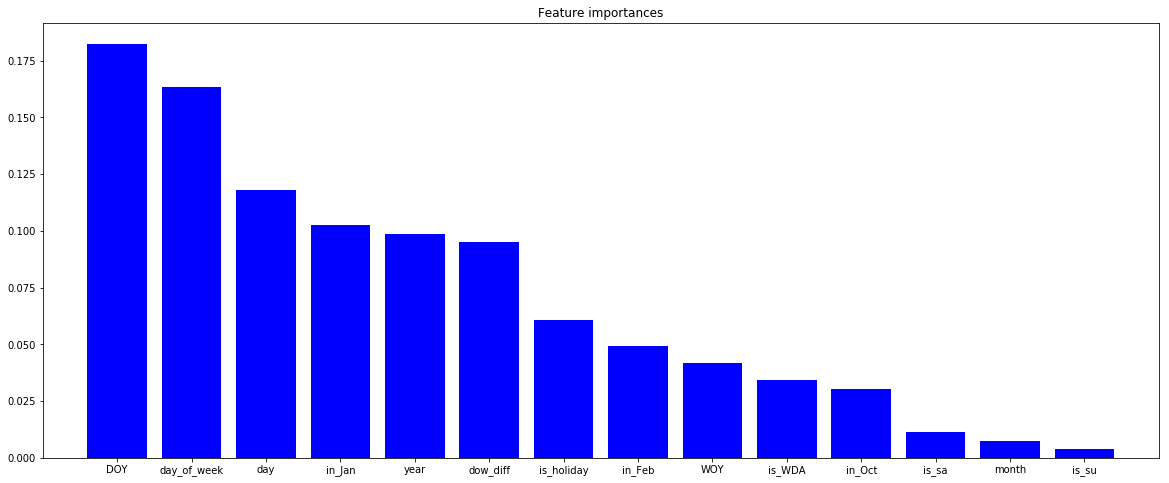

In [11]:
import matplotlib.pyplot as plt
print("Feature ranking:")
feature_names = [u"day_of_week",u"dow_diff",u"is_sa",u"is_su",u"year",u"month",\
                 u"day",u"DOY",u"WOY",u"is_holiday",u"is_WDA",u"in_Jan",u"in_Oct",u"in_Feb"]
feature_importances = xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

for f in indices:
    print("feature %s (%f)" % (feature_names[f], feature_importances[f]))

plt.figure(figsize=(20,8))
plt.title("Feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices],
       color="b",align="center")
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices])
plt.xlim([-1, train_X.shape[1]])
plt.show()

mse: 179031.61934608532
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1032 entries, 2013-01-02 to 2015-10-30
Data columns (total 3 columns):
cnt          1032 non-null float64
train_cnt    1032 non-null float64
cnt_diff     1032 non-null float64
dtypes: float64(3)
memory usage: 32.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 1507 entries, 2013-01-02 to 2017-02-16
Data columns (total 24 columns):
index                1307 non-null float64
date_t.1             1507 non-null object
date_ext_t           1507 non-null object
cnt                  1507 non-null float64
date                 1507 non-null float64
day_of_week          1507 non-null int64
dow_diff             1507 non-null float64
is_sa                1507 non-null float64
is_su                1507 non-null float64
year                 1507 non-null int64
month                1507 non-null int64
day                  1507 non-null int64
DOY                  1507 non-null int64
WOY                  1507 non-null in

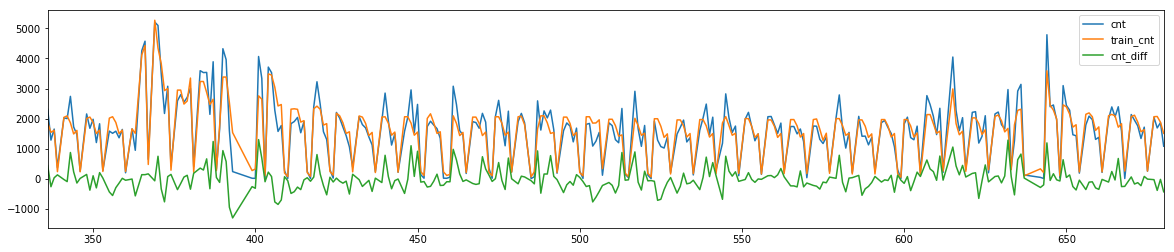

In [12]:
%matplotlib inline
test_X = all_feature_df[1192:][[u"day_of_week",u"dow_diff",u"is_sa",u"is_su",\
                                u"year",u"month",u"day",u"DOY",u"WOY",u"is_holiday",u"is_WDA",\
                                u"in_Jan",u"in_Oct",u"in_Feb"]].values
# print(all_feature_df[1192:1195])
result = xgb_model.predict(test_X)
result_train = xgb_model.predict(train_X)
# result_train[:100]
result_train_cmp_df = pd.DataFrame([pd.Series(train_y.reshape(train_y.shape[0])),pd.Series(result_train)]).T
result_train_cmp_df.columns = ["cnt","train_cnt"]
# 只取真实数据
result_train_cmp_df  = result_train_cmp_df[result_train_cmp_df.cnt > 0]
result_train_cmp_df["cnt_diff"] = result_train_cmp_df.cnt - result_train_cmp_df.train_cnt
result_train_cmp_df[300:600].plot(figsize=(20,4))
result_train_cmp_df.set_index(pd.to_datetime(all_data_df.index.tolist()[:1032]),inplace=True)
print("mse:",sum(result_train_cmp_df["cnt_diff"]*result_train_cmp_df["cnt_diff"].T)/len(result_train_cmp_df["cnt_diff"]))
# pd.Series(train_y.reshape(1032))
# result_cmp_df[:10]
# all_data_df.loc[:"2016-04-07",["date_ext_t","cnt","day_of_week"]]
# result_cmp_df = pd.concat([all_data_df.loc[0:1192,["date_t","cnt","day_of_week"]],result_cmp_df],axis=1)
# result_train_cmp_df.reset_index(inplace=True)
print(result_train_cmp_df.info())
print(all_data_df.info())
# result_train_cmp_df.set_index(result_train_cmp_df.index.tolist(),inplace=True)
print(result_train_cmp_df.head())
result_train_cmp_df = pd.concat([all_data_df.loc[:"2016-04-07",["date_ext_t","day_of_week","year","month","WOY","day","date"]],result_train_cmp_df],axis=1)
# result_train_cmp_df.columns
result_train_cmp_df.to_csv("result.txt",sep="\t")

In [13]:
# print(all_data_df.shape,all_data_df.columns.tolist(),all_data_df.loc["2016-04-09":,["date"]],len(result))
# result_df.head(10)

test_date = all_data_df.loc["2016-04-08":,["date"]].values
test_date=test_date.reshape(len(test_date))
print(type(test_date),test_date.shape,result.size)

result_df =  pd.DataFrame([test_date,result.astype(int)])
result_df = result_df.T
result_df.columns = ["date","cnt"]
result_df.head()
result_df = result_df[result_df.date > 0]
result_leak_df = all_data_df.loc["2016-04-07",["date","cnt"]]
result_leak_df.head()
# result_df = result_df.reset_index()

pd.DataFrame(result_leak_df).T.head()
result_df = pd.concat([pd.DataFrame(result_leak_df).T.astype(int),result_df.astype(int)])

# # print(result_df.shape)
filename = pd.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
result_df.loc[:,["date","cnt"]].to_csv(filename+"_us_"+".txt",sep="\t",header=False,index=False)

<class 'numpy.ndarray'> (315,) 315


## 效果评估

In [14]:
xgb_model.score(train_X, train_y)

0.8964131774944158

In [15]:
predict_y = xgb_model.predict(train_X)

In [16]:
predict_y

array([  19.273077,  504.261   , 4721.608   , ..., 3363.4019  ,
       2171.8435  , 1723.4283  ], dtype=float32)